In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from statistics import mean
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/IPB/MATKUL/TINGKAT 3/SMT 6/Data Mining/KULIAH/Kaggle Competition/training.csv')

In [4]:
#drop kolom sample_id
df_train = df_train.drop(['sample_id'], axis=1)

In [5]:
#encode kolom Target
label_encoder = LabelEncoder()

df_train_encoded = df_train.copy()

df_train_encoded['Target'] = label_encoder.fit_transform(df_train['Target'])

df_train_encoded

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,2
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,2
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2,12,1,17,0,1,1,22,27,10,...,0,5,5,0,0.000000,0,7.6,2.6,0.32,0
3996,1,1,1,16,1,1,1,1,1,10,...,0,6,13,2,12.000000,0,12.7,3.7,-1.70,0
3997,4,12,2,13,1,12,1,13,14,5,...,0,8,11,8,12.300000,0,10.8,1.4,1.74,2
3998,4,4,1,12,1,15,1,13,14,5,...,3,7,11,3,14.166667,0,12.4,0.5,1.79,0


In [6]:
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [7]:
#split data into 80 and 20
from sklearn.model_selection import train_test_split
X = df_train_encoded.drop(['Target'], axis=1)
y = df_train_encoded['Target']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

smt = SMOTE(random_state = 42)
X, y = smt.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SVM

In [ ]:
# Define the hyperparameter grid
param_grid_svm = {
    'C': [0.01, 0.1, 1],  # Regularization parameter, best = 1
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type, best = rbf
    'gamma': [0.01, 0.1],  # Kernel coefficient (for 'rbf', 'poly', 'sigmoid'), best = 0.1
    'degree': [2,3,4] #best = 2
}

# Create the SVC model object
svc_model = SVC(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(svc_model, param_grid_svm, cv=cv, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
Best score:  0.8240972222222224


In [13]:
# ==== 5. Evaluasi pada Berbagai Ukuran Data ====
train_accuracies = []
val_accuracies = []
sizes = [0.1, 0.3, 0.5, 0.7, 1.0]

for size in sizes:
    subset_size = int(len(X_train) * size)
    X_sub = X_train[:subset_size]
    y_sub = y_train[:subset_size]

    model = SVC(kernel='rbf', C=1, gamma=0.1, degree=2, random_state=42)
    model.fit(X_sub, y_sub)

    y_sub_pred = model.predict(X_sub)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_sub, y_sub_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    val_accuracies.append(test_acc)

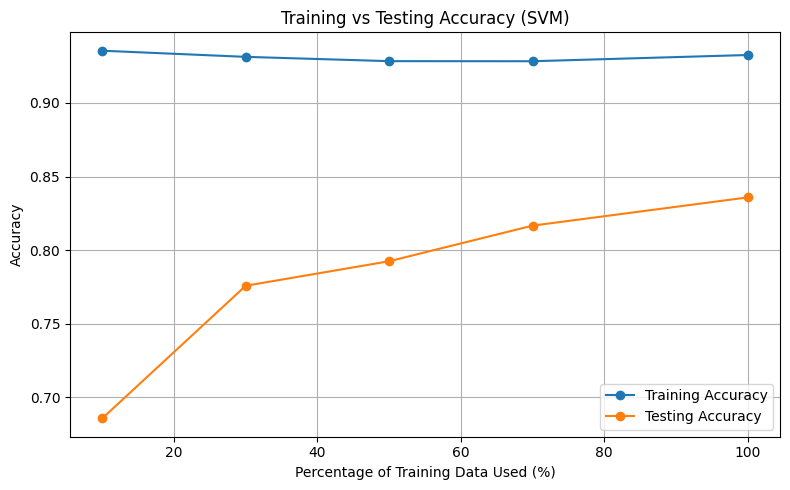

In [14]:
# ==== 5. Grafik Akurasi ====
plt.figure(figsize=(8, 5))
plt.plot([int(s*100) for s in sizes], train_accuracies, label='Training Accuracy', marker='o')
plt.plot([int(s*100) for s in sizes], val_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy (SVM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# ==== 7. Final Training dan Evaluasi ====
#Best set of hyperparameters:  {'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}

final_model_svc = SVC(kernel='rbf', C=1, degree = 2, gamma=0.1, random_state=42,probability = True)
final_model_svc.fit(X_train, y_train)

# Akurasi Training dan Testing
train_acc_final = accuracy_score(y_train, final_model_svc.predict(X_train))
test_acc_final = accuracy_score(y_test, final_model_svc.predict(X_test))

print(f"🎯 Final Training Accuracy: {train_acc_final:.4f}")
print(f"📊 Final Testing Accuracy: {test_acc_final:.4f}")

🎯 Final Training Accuracy: 0.9325
📊 Final Testing Accuracy: 0.8358


hasil_prediksi (11) = 0.72864

# RANDOM FOREST

In [ ]:
#randomized search random forest

param_dist_random_forest = {
    'n_estimators': np.arange(50, 250, 50),  # 50, 100, 150, 200
    'max_depth': [None] + list(np.arange(5, 35, 5)),  # None, 5, 10, 15, 20, 25, 30
    'min_samples_split': np.arange(2, 11, 2),  # 2, 4, 6, 8, 10
    'min_samples_leaf': np.arange(1, 5),  # 1, 2, 3, 4
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state = 42)

# RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_random_forest,
    n_iter=50,  # Jumlah kombinasi parameter yang akan dicoba
    cv=cv,  # Cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Gunakan semua core CPU
    verbose=1,
    random_state=42
)

random_search_rf.fit(X_train, y_train)

print(random_search_rf.best_params_) #{'n_estimators': np.int64(50), 'min_samples_split': np.int64(4), 'min_samples_leaf': np.int64(1), 'max_features': 'log2', 'max_depth': None, 'class_weight': None, 'bootstrap': False}

Fitting 15 folds for each of 50 candidates, totalling 750 fits
{'n_estimators': np.int64(50), 'min_samples_split': np.int64(4), 'min_samples_leaf': np.int64(1), 'max_features': 'log2', 'max_depth': None, 'class_weight': None, 'bootstrap': False}


In [21]:
# ==== 5. Evaluasi pada Berbagai Ukuran Data ====
train_accuracies = []
val_accuracies = []
sizes = [0.1, 0.3, 0.5, 0.7, 1.0]

for size in sizes:
    subset_size = int(len(X_train) * size)
    X_sub = X_train[:subset_size]
    y_sub = y_train[:subset_size]

    model = RandomForestClassifier(n_estimators = 50, min_samples_split = 4, min_samples_leaf = 1, max_features = 'log2', max_depth = None, class_weight = None, bootstrap = False)
    model.fit(X_sub, y_sub)

    y_sub_pred = model.predict(X_sub)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_sub, y_sub_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    val_accuracies.append(test_acc)

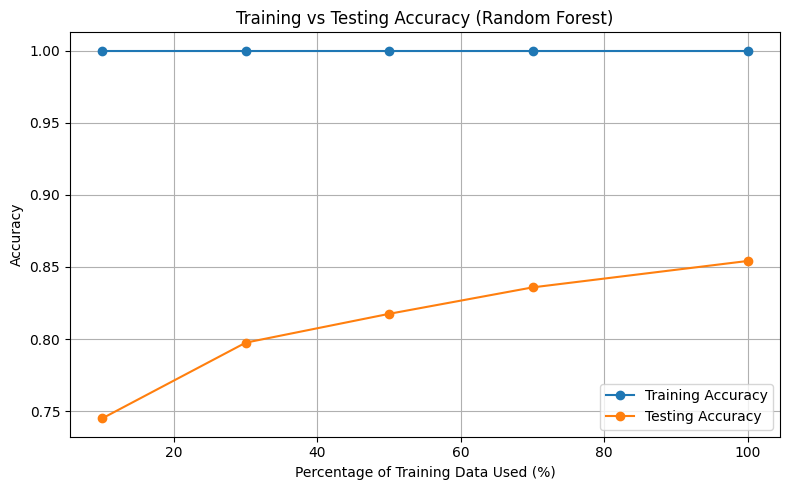

In [12]:
# ==== 6. Grafik Akurasi ====
plt.figure(figsize=(8, 5))
plt.plot([int(s*100) for s in sizes], train_accuracies, label='Training Accuracy', marker='o')
plt.plot([int(s*100) for s in sizes], val_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy (Random Forest)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# ==== 7. Final Training dan Evaluasi ====
final_model_rf = RandomForestClassifier(n_estimators = 50,
                                        min_samples_split = 4,
                                        min_samples_leaf = 1,
                                        max_features = 'log2',
                                        max_depth = None,
                                        class_weight = None,
                                        bootstrap = False)
final_model_rf.fit(X_train, y_train)

# Akurasi Training dan Testing
train_acc_final = accuracy_score(y_train, final_model_rf.predict(X_train))
test_acc_final = accuracy_score(y_test, final_model_rf.predict(X_test))

print(f"🎯 Final Training Accuracy: {train_acc_final:.4f}")
print(f"📊 Final Testing Accuracy: {test_acc_final:.4f}")

🎯 Final Training Accuracy: 1.0000
📊 Final Testing Accuracy: 0.8525


hasil_prediksi (12) = 0.79396

In [24]:
# feature importance


# Ambil nama-nama fitur dari X_train
feature_names = X_train.columns

# Ambil nilai feature importance
importances = final_model_rf.feature_importances_

# Gabungkan ke dalam DataFrame biar mudah dibaca dan diurutkan
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Tampilkan top-n fitur paling penting (misal top 20)
print("\nTop Feature Importances:")
#print(feat_imp_df.head(20))
print(feat_imp_df)


Top Feature Importances:
                                           Feature  Importance
28             Curricular units 2nd sem (approved)    0.163303
22             Curricular units 1st sem (approved)    0.105526
29                Curricular units 2nd sem (grade)    0.081400
23                Curricular units 1st sem (grade)    0.058416
27          Curricular units 2nd sem (evaluations)    0.052817
21          Curricular units 1st sem (evaluations)    0.044955
17                               Age at enrollment    0.043366
14                         Tuition fees up to date    0.040732
26             Curricular units 2nd sem (enrolled)    0.036736
3                                           Course    0.032774
9                              Mother's occupation    0.030570
10                             Father's occupation    0.030007
20             Curricular units 1st sem (enrolled)    0.027683
7                           Mother's qualification    0.025004
32                           

In [25]:
# Ambil top 20 fitur terpenting
top_20_features = feat_imp_df.head(20)['Feature'].tolist()

# Subset X_train dan X_test hanya dengan fitur-fitur tersebut
X_train_top20 = X_train[top_20_features]
X_test_top20 = X_test[top_20_features]

# latih ulang model
final_model_rf.fit(X_train_top20, y_train)

# Akurasi Training dan Testing
train_acc_final = accuracy_score(y_train, final_model_rf.predict(X_train_top20))
test_acc_final = accuracy_score(y_test, final_model_rf.predict(X_test_top20))

print(f"🎯 Final Training Accuracy: {train_acc_final:.4f}")
print(f"📊 Final Testing Accuracy: {test_acc_final:.4f}")

🎯 Final Training Accuracy: 0.9998
📊 Final Testing Accuracy: 0.8433


hasil_prediksi (17)

In [26]:
# Ambil top 10 fitur terpenting
top_10_features = feat_imp_df.head(10)['Feature'].tolist()

# Subset X_train dan X_test hanya dengan fitur-fitur tersebut
X_train_top10 = X_train[top_10_features]
X_test_top10 = X_test[top_10_features]

# latih ulang model
final_model_rf.fit(X_train_top10, y_train)

# Akurasi Training dan Testing
train_acc_final = accuracy_score(y_train, final_model_rf.predict(X_train_top10))
test_acc_final = accuracy_score(y_test, final_model_rf.predict(X_test_top10))

print(f"🎯 Final Training Accuracy: {train_acc_final:.4f}")
print(f"📊 Final Testing Accuracy: {test_acc_final:.4f}")

🎯 Final Training Accuracy: 0.9825
📊 Final Testing Accuracy: 0.8075


hasil_prediksi (18)

# XGBoost

In [ ]:
#grid search xgboost

param_dist_xgb = {
    'n_estimators': np.arange(50, 300, 50),  # 50, 100, 150, 200, 250
    'max_depth': np.arange(3, 12),  # 3 to 11
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'subsample': np.linspace(0.6, 1.0, 5),  # 0.6, 0.7, 0.8, 0.9, 1.0
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': [0, 0.1, 0.2, 0.5, 1],
    'min_child_weight': np.arange(1, 6),  # 1 to 5
    'reg_alpha': [0, 0.01, 0.1, 1, 10],  # L1 regularization
    'reg_lambda': [0, 0.01, 0.1, 1, 10],  # L2 regularization
    'scale_pos_weight': [1, 5, 10]  # Untuk klasifikasi tidak seimbang
}

xgb_clf = XGBClassifier(random_state=42, eval_metric='error')

# RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist_xgb,
    n_iter=50,  # Jumlah kombinasi parameter yang akan dicoba
    cv=cv,  # Cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Gunakan semua core CPU
    verbose=1,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)

print(random_search_xgb.best_params_)  #{'subsample': np.float64(0.9), 'scale_pos_weight': 5, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': np.int64(250), 'min_child_weight': np.int64(2), 'max_depth': np.int64(9), 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': np.float64(0.9)}

Fitting 15 folds for each of 50 candidates, totalling 750 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:14:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


{'subsample': np.float64(0.9), 'scale_pos_weight': 5, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': np.int64(250), 'min_child_weight': np.int64(2), 'max_depth': np.int64(9), 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': np.float64(0.9)}


In [ ]:
# ==== 5. Evaluasi pada Berbagai Ukuran Data ====
train_accuracies = []
val_accuracies = []
sizes = [0.1, 0.3, 0.5, 0.7, 1.0]

for size in sizes:
    subset_size = int(len(X_train) * size)
    X_sub = X_train[:subset_size]
    y_sub = y_train[:subset_size]

    model = XGBClassifier(subsample = 0.9,
                          scale_pos_weight = 5,
                          reg_lambda = 0.1,
                          reg_alpha = 0,
                          n_estimators = 250,
                          min_child_weight = 2,
                          max_depth = 9,
                          learning_rate = 0.1,
                          gamma = 0,
                          colsample_bytree = 0.9)
    model.fit(X_sub, y_sub)

    y_sub_pred = model.predict(X_sub)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_sub, y_sub_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    val_accuracies.append(test_acc)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:46:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:46:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:46:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:46:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:46:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weigh

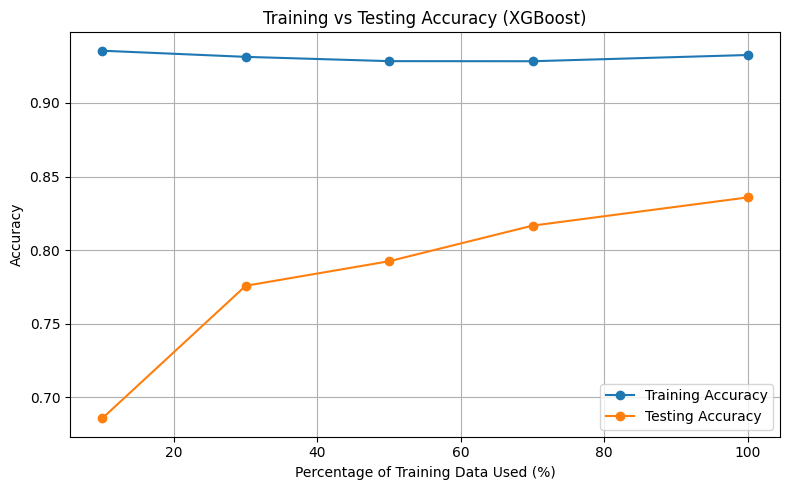

In [15]:
# ==== 5. Grafik Akurasi ====
plt.figure(figsize=(8, 5))
plt.plot([int(s*100) for s in sizes], train_accuracies, label='Training Accuracy', marker='o')
plt.plot([int(s*100) for s in sizes], val_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy (XGBoost)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# ==== 7. Final Training dan Evaluasi ====

final_model_xgb = XGBClassifier(subsample = 0.9,
                          scale_pos_weight = 5,
                          reg_lambda = 0.1,
                          reg_alpha = 0,
                          n_estimators = 250,
                          min_child_weight = 2,
                          max_depth = 9,
                          learning_rate = 0.1,
                          gamma = 0,
                          colsample_bytree = 0.9)
final_model_xgb.fit(X_train, y_train)

# Akurasi Training dan Testing
train_acc_final = accuracy_score(y_train, final_model_xgb.predict(X_train))
test_acc_final = accuracy_score(y_test, final_model_xgb.predict(X_test))

print(f"🎯 Final Training Accuracy: {train_acc_final:.4f}")
print(f"📊 Final Testing Accuracy: {test_acc_final:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:00:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


🎯 Final Training Accuracy: 1.0000
📊 Final Testing Accuracy: 0.8683


hasil_prediksi (13) = 0.76381

# Ensemble learning

In [ ]:
estimator = []
estimator.append(('SVC', final_model_svc))
estimator.append(('RF', final_model_rf))
estimator.append(('XGB', final_model_xgb))

In [ ]:
# Voting Classifier with hard voting
hard_voting = VotingClassifier(estimators = estimator, voting ='hard') #hasil_prediksi (14) = 0.76884
hard_voting.fit(X_train, y_train)
y_pred = hard_voting.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:58:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# accuracy_score metric to predict Accuracy
score_hard = accuracy_score(y_test, y_pred)
print("Hard Voting Score: %.2f" % score_hard)

Hard Voting Score: 0.86


In [ ]:
soft_voting = VotingClassifier(estimators = estimator, voting ='soft') #hasil prediksi (15) = 0.76381
soft_voting.fit(X_train, y_train)
y_pred = soft_voting.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:58:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
score_soft = accuracy_score(y_test, y_pred)
print("Soft Voting Score: %.2f" % score_soft)

Soft Voting Score: 0.87


In [ ]:
# Definisikan base models

# Meta model (default: LogisticRegression)
stacking_clf = StackingClassifier(
    estimators=estimator,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train) #hasil prediksi (16) = 0.76381
print("Stacking Accuracy:", stacking_clf.score(X_test, y_test))

Stacking Accuracy: 0.8666666666666667


setelah hasil prediksi ensemble learning di submit, akurasi leaderboard kaggle turun sehingga pendekatan ini tidak digunakan

# MAKE PREDICTIONS

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/IPB/MATKUL/TINGKAT 3/SMT 6/Data Mining/KULIAH/Kaggle Competition/testing.csv')

In [ ]:
df_test_selected = df_test.drop(['sample_id'], axis=1)

In [ ]:
df_test_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 34 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  424 non-null    int64  
 1   Application mode                                424 non-null    int64  
 2   Application order                               424 non-null    int64  
 3   Course                                          424 non-null    int64  
 4   Daytime/evening attendance                      424 non-null    int64  
 5   Previous qualification                          424 non-null    int64  
 6   Nacionality                                     424 non-null    int64  
 7   Mother's qualification                          424 non-null    int64  
 8   Father's qualification                          424 non-null    int64  
 9   Mother's occupation                        

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4000 non-null   int64  
 1   Application mode                                4000 non-null   int64  
 2   Application order                               4000 non-null   int64  
 3   Course                                          4000 non-null   int64  
 4   Daytime/evening attendance                      4000 non-null   int64  
 5   Previous qualification                          4000 non-null   int64  
 6   Nacionality                                     4000 non-null   int64  
 7   Mother's qualification                          4000 non-null   int64  
 8   Father's qualification                          4000 non-null   int64  
 9   Mother's occupation                      

In [ ]:
df_test_selected_scaled = scaler.transform(df_test_selected)

In [ ]:
df_test_selected = pd.DataFrame(scaler.transform(df_test_selected), columns=df_test_selected.columns)

In [ ]:
y_pred = final_model_rf.predict(df_test_selected)

In [ ]:
y_pred_labels = label_encoder.inverse_transform(y_pred)

In [ ]:
df_prediksi = pd.DataFrame({
    "sample_id": df_test["sample_id"],
    "Target": y_pred_labels
})

df_prediksi.to_csv("hasil_prediksi.csv", index=False)